### **Topic Modeling** : 

In the previous notebook, I expeirmented with ```newsAPI```, but the primary issue with this package is that it only provides truncated articles. For the purpose of my project, I wanted complete articles.

In [23]:
import torch
import spacy
import json
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import CamembertTokenizer, CamembertModel
import warnings
from bertopic import BERTopic
import re # regular expressions
import unicodedata

#### Step 1 : Load Processed Data

In [9]:
# Loading the "enriched collection of articles from the JSON file, where they have been previously stored.
file_path = "../NLP Project/enriched_french_news_articles.json"

with open(file_path, encoding = "utf-8") as f:
    articles = json.load(f)    

# Storing only the "full_text" part of all the articles in a list.
enriched_articles = [article.get("full_text", "") for article in articles]

In [10]:
print(enriched_articles[0][:150],"...")

Néanmoins, la marque coréenne assure avoir finalement corrigé la chose. Il faut dire que le déploiement a été retardé à plusieurs reprises, après la d ...


In [11]:
print("This list enriched_articles contains", len(enriched_articles), "articles.")

This list enriched_articles contains 525 articles.


Just as a sanity check, it might be useful to plot a ```histogram``` showing the distribution of the numbers of words per article.

Shortest article has 216 words
Longest article has 54118 words


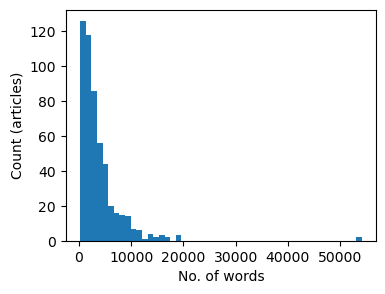

In [12]:
lengths = [len(article) for article in enriched_articles]
print(f"Shortest article has {min(lengths)} words")
print(f"Longest article has {max(lengths)} words")
plt.figure(figsize = (4,3))
plt.hist(lengths, bins = 50)
plt.xlabel('No. of words')
plt.ylabel('Count (articles)')
plt.show()
del lengths

At this stage, we have a list called enriched_articles where each item is basically the primary article content. We have 500+ such article as our primary data set.

#### Step 2 : **```Tokenization```**.

*Must download ```spaCy```’s French model to tokenize, lemmatize, and remove stopwords.*

In [14]:
nlp = spacy.load("fr_core_news_sm")

**Note** : Lemmatisation is the process of reducing the different forms of a word to one single form, for example, reducing "builds", "building", or "built" to the lemma "build".

**spaCy.nlp** : Tokenisation, Lemmatization and some cleaning.

In [16]:
import re
from nltk.tokenize import sent_tokenize

def preprocess_text(text):

    # Run spaCy lemmatization on cleaned text
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Apply preprocessing to all texts
cleaned_lemmatized_texts = [preprocess_text(t) for t in enriched_articles]

KeyboardInterrupt: 

In [17]:
cleaned_lemmatized_texts[0]

'marque coréen assurer finalement corriger chose falloir déploiement être retarder reprise découverte bug problème corriger galaxy ultrer pouvoir profiter interface récent panne spotify application marche impossible écouter musique pann importance toucher spotify mercredi plateforme streaming impossible lancer utilisateur partout monde finalement heure pann musique reprendre connaître prix break électrique chinois recharger minute arriver bientôt europe zeekr marquer esprit présentation zeekr gt break électrique capable charger minute présent ignorer prix véhicule lancer connaître zeekr gt proposer chine partir yuan équivaloir euro savoir prix lancer break europe'

**Tokenization** : Dividing text into words or sub-words. 

```CamembertTokenizer``` and ```CamembertModel``` are the ideal choice for this project because they are specifically designed and pretrained for the French language, ensuring they effectively capture the unique linguistic nuances, grammar, and vocabulary inherent to French text. Unlike multilingual or English-centric models, ```CamemBERT``` provides contextual embeddings that accurately reflect the meaning and context of French sentences, which is critical for generating high-quality semantic representations. This precision enhances the performance of downstream tasks like topic modeling and clustering by enabling the model to distinguish subtle differences in meaning and usage, leading to more coherent and meaningful topic discovery within the French news dataset.

In [18]:
# CamembertTokenizer splits raw French text into tokens (subword units) that the model understands.
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# CamembertModel is the pretrained transformer model for French, which outputs contextual embeddings for input tokens.
model = CamembertModel.from_pretrained("camembert-base")

**Embedding** : Assigning each token a vector. 

The ```get_embedding``` function (below) takes a French text string as input, tokenizes it using ```CamembertTokenizer```, and passes the tokens through the pretrained CamembertModel to generate a contextual embedding. It extracts the embedding of the special [CLS] token, which serves as a fixed-size vector representation capturing the overall semantic meaning of the input text, ready for use in clustering or other downstream tasks.

In [19]:
# This function generates a numerical embedding vector for a given text (article, in my case) using a pretrained transformer model. 
# It tokenizes the input text, feeds it through the model without computing gradients (in inference mode), and 
# returns the embedding of the special `[CLS]` token, which captures the overall semantic representation of the text.

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:,0,:].squeeze().numpy()

The following process (embedding) takes a considerable amount of time ~ 5 - 10 minutes.

In [20]:
embeddings = [get_embedding(t) for t in cleaned_lemmatized_texts]

**Topic modelling using BERTopic** :

*BERTopic is a powerful topic modeling technique that combines transformer-based embeddings with clustering algorithms to discover meaningful themes within large text corpora. By leveraging pre-trained language models, BERTopic captures rich semantic information beyond simple word frequency, enabling it to group documents based on contextual similarity. It then applies dimensionality reduction and density-based clustering to identify coherent topics, which are summarized with representative keywords. This approach results in interpretable and dynamic topic representations, making BERTopic especially effective for analyzing complex and diverse textual data.*

In [21]:
import time
start_time = time.time()
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(cleaned_lemmatized_texts)
print("--- %s seconds ---" % (time.time() - start_time))

--- 131.14465165138245 seconds ---


In [22]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,208,-1_tre_libre_bien_mai,"[tre, libre, bien, mai, faire, entreprise, fra...",[publier mai mettre jour mai lir tard google a...
1,0,52,0_prix_point_aspirateur_robot,"[prix, point, aspirateur, robot, plastique, bi...",[lancer deebot omni modèle évolué cuvée aspira...
2,1,52,1_film_rinaldi_tre_festival,"[film, rinaldi, tre, festival, histoire, anne,...",[temps lecture minute saviez festival cannes p...
3,2,43,2_galaxy_samsung_smartphone_huawei,"[galaxy, samsung, smartphone, huawei, fi, wi, ...",[test huawei watch montre design moderne taill...
4,3,28,3_trump_revenu_impt_social,"[trump, revenu, impt, social, donald, fiscal, ...",[signal confus chine clairement cible principa...


In [149]:
# Generate labels
topic_labels = {
    0: "Smartphones & Tech Gadgets",
    1: "Cinema & Culture",
    2: "Home Appliances",
    3: "Consumer Electronics",
    4: "Economy & Finance",
    5: "US Politics & Society",
    6: "French Right-Wing Politics",
    7: "Financial Scams & Social Issues",
    8: "Computer Hardware & GPUs",
    9: "Environment & Food",
    10: "Middle East Politics"
}
topic_model.set_topic_labels(topic_labels)

In [184]:
topic_model.get_topic_info().head()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,197,-1_tre_libre_bien_entreprise,tre - libre - bien,"[tre, libre, bien, entreprise, faire, mai, pou...",[fois julie entendre culture entreprise venir ...
1,0,54,0_galaxy_samsung_smartphone_fi,Smartphones & Tech Gadgets,"[galaxy, samsung, smartphone, fi, wi, huawei, ...",[batterie silicium optimisation ia iphon air a...
2,1,52,1_film_rinaldi_tre_festival,Cinema & Culture,"[film, rinaldi, tre, festival, anne, histoire,...",[temps lecture minute saviez festival cannes p...
3,2,49,2_prix_point_aspirateur_robot,Home Appliances,"[prix, point, aspirateur, robot, plastique, sy...",[lancer deebot omni modèle évolué cuvée aspira...
4,3,29,3_point_prix_qualit_exemple,Consumer Electronics,"[point, prix, qualit, exemple, chien, shot, im...",[arrivée fleuron sony perturbe inévitablemer h...


In [183]:
topic_model.visualize_barchart()

In [7]:
topic_model.visualize_heatmap(custom_labels=True)

NameError: name 'topic_model' is not defined

In [124]:
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

embeddings_2d = reducer.fit_transform(embeddings)
embeddings_2d_array = np.array(embeddings_2d)
embeddings_array = np.array(embeddings)

In [128]:
print("Docs:", len(cleaned_lemmatized_texts))
print("Embeddings shape:", embeddings_array.shape)
print("2D embeddings shape:", embeddings_2d_array.shape)
print("Topics length:", len(topics))


Docs: 525
Embeddings shape: (525, 768)
2D embeddings shape: (525, 2)
Topics length: 525


In [140]:
topic_labels

['tre - libre - bien',
 'galaxy - samsung - smartphone',
 'film - rinaldi - tre',
 'prix - point - aspirateur',
 'point - prix - qualit',
 'euro - france - milliard',
 'trump - revenu - impt',
 'bruno - tat - retailleau',
 'valuation - recherche - tre',
 'neuf - rt - geforce',
 'eau - animal - fromage',
 'gaza - immigration - isralien']

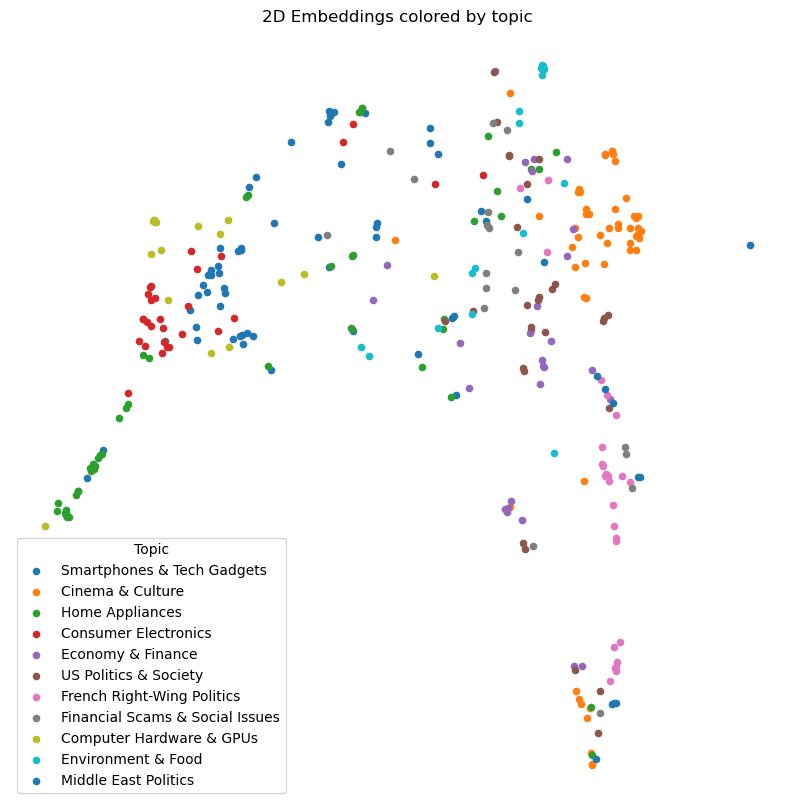

In [155]:
unique_topics = sorted(set(topics))
fig, ax = plt.subplots(figsize=(10, 10))

for t in unique_topics:
    if t == -1:
        continue
    mask = np.array(topics) == t
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        s=20,
        label=topic_labels[t],
        cmap='tab20' if False else None
    )

ax.set_title("2D Embeddings colored by topic")
ax.legend(title="Topic")
ax.set_axis_off()
plt.show()

In [156]:
for t in topic_model.get_topic_freq().Topic.drop(0):
    print("\n==== Topic", t, "====")
    for word, score in topic_model.get_topic(t)[:10]:
        print(f"{word:10s} {score:.4f}")
    print("\nExample:", topic_model.get_representative_docs(t)[0][:200], "…")


==== Topic 0 ====
galaxy     0.0495
samsung    0.0443
smartphone 0.0313
fi         0.0281
wi         0.0279
huawei     0.0269
batterie   0.0251
watch      0.0251
appareil   0.0246
bande      0.0221

Example: batterie silicium optimisation ia iphon air apple bien bousculer concurrence samsung apple affronter créer smartphone fin autonomie principal défi surmonter apple mise batterie silicium dense intellig …

==== Topic 1 ====
film       0.0315
rinaldi    0.0257
tre        0.0201
festival   0.0161
anne       0.0146
histoire   0.0145
faire      0.0130
monde      0.0127
grand      0.0125
astrix     0.0124

Example: temps lecture minute saviez festival cannes plein film voir année long métrage inédit format beal moche attendre signé grand auteur interpréter grand vedette traiter grand sujet arriver surgisse milie …

==== Topic 2 ====
prix       0.0306
point      0.0231
aspirateur 0.0228
robot      0.0202
plastique  0.0192
systme     0.0180
aspiration 0.0174
petit      0.0168
efficace   0.

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

tokenized_texts = [doc.split() for doc in cleaned_lemmatized_texts]

# Create Gensim dictionary and corpus
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# 3. Extract topics from BERTopic (list of (word, weight) tuples)
all_topics = topic_model.get_topics()

# 4. Convert topics to list of words (top 10 words per topic)
top_n = 10
topics_wordlists = []
for topic_id in all_topics:
    topic = all_topics[topic_id]
    words = [word for word, weight in sorted(topic, key=lambda x: -x[1])[:top_n]]
    topics_wordlists.append(words)

# 5. Compute coherence scores for each topic
coherence_values = []
for topic_words in topics_wordlists:
    cm = CoherenceModel(
        topics=[topic_words],
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_values.append(cm.get_coherence())

# 6. Print coherence results
avg_coherence = np.mean(coherence_values)
print(f"\nAverage topic coherence (c_v): {avg_coherence:.4f}\n")

for i, score in enumerate(coherence_values):
    print(f"Topic {i}: coherence = {score:.4f}")

# 7. Print document counts per topic
import collections
topic_counts = collections.Counter(topic_model.get_topic_freq().Topic)
print("\nDocument counts per topic:")
for topic_id, count in sorted(topic_counts.items()):
    print(f"Topic {topic_id}: {count} docs")

# 8. Flag topics with coherence < 0.35
low_coherence_topics = [i for i, c in enumerate(coherence_values) if c < 0.35]
if low_coherence_topics:
    print("\nTopics with low coherence (<0.35):", low_coherence_topics)
else:
    print("\nAll topics have acceptable coherence.")
